In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-1rp0g_7k
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-1rp0g_7k
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=aa6a39006e705fbb5c85f7547b1b2e15746994ccefc6d66880a9cca7cd7192d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvso7js7/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


1024/l480


```
# This is formatted as code
```



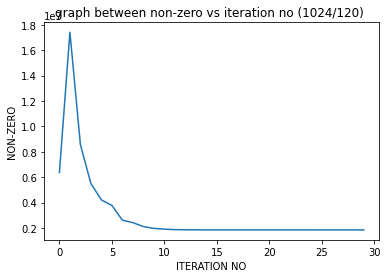

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

# x axis values
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
# corresponding y axis values
y = [  6374505,
   17406000 ,
   8562176 ,
   5503360 ,
   4215712 ,
   3779040 ,
   2620832 ,
   2425696 ,
  2118688 ,
   1975232 ,
   1917600 ,
   1879072 ,
  1866112 ,
   1862048 ,
   1858560 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
  1857536 ,
   1856512 ,
   1856512 ,
   1856512 ,
   1856512 ,
  1855488 ]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('ITERATION NO')
# naming the y axis
plt.ylabel('NON-ZERO')

# giving a title to my graph
plt.title('graph between non-zero vs iteration no (1024/120) ')

# function to show the plot
plt.show()


1024/l120

In [ ]:
%%cu
#include <fstream>
#include <iostream>
#include <string>
#include <vector>
#include <boost/algorithm/string.hpp>
#include <stdio.h>
#include <string.h>
#define row 60000
#define col 1024
#include <sys/time.h>
using namespace std;
using namespace boost::algorithm;
using std::cout; using std::cerr;
using std::endl; using std::string;
using std::ifstream; using std::vector;


__global__ void passed_failed(int* cat_120, int* cat_calculated)
{
    int index=blockIdx.x*blockDim.x+threadIdx.x;
    if(index<1812)

    {
        if(cat_120[index]!=cat_calculated[index])
       {
         printf("Test Failed \n");
           return;
        }
        printf("index %d ,v1 %d = v2 %d \n " ,index,cat_120[index],cat_calculated[index]);
    }

     __syncthreads();
    printf("Test Passed \n");
}

__global__ void count(float* M,int *count,int*Tcd)
{
    int index=blockIdx.x*blockDim.x+threadIdx.x;

   // int index_cnt=0;
    if(index<60000   )
    {
        for(int i=0;i<1024;i++)
        {
          if(M[index*1024+i]!=0)
          {
              //printf("Active %d ",index);

              //Tcd[index_cnt]=index;
              //index_cnt =index_cnt+1;

              atomicAdd(count,1);
              break;
          }
        }
          __syncthreads();
    }
     __syncthreads();

}

__global__ void Kernel(float * M,float* N,float * P)
{

    int Row=blockIdx.y*blockDim.y+threadIdx.y;
    int Col=blockIdx.x*blockDim.x+threadIdx.x;

    if(Row<60000 && Col < 1024)
    {
        float product=0;
        for(int k=0;k<1024;k++)
            product+=M[Row*1024+k]*N[k*1024+Col];

    //    printf("Pro %f col > %d ",product , Col);

        product = product - 0.3;
        if((product)<0)
        {
            product = 0;
        }
        if((product) >32)
        {
            product = 32;
        }
        P[Row*1024+Col]=product;
    }
    __syncthreads();
}
int main(int argc, char** argv) {

    ifstream fin("drive/MyDrive/sparse-images-1024.tsv");
    string line;
    float *y_o;
    int N=60000*1024*sizeof(float);
    y_o=(float*)malloc(N);
    for(int i=0; i<row*col; i++){
        y_o[i]=0;
    }

    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);

        y_o[(r-1)*1024+(c-1)]=1;
    }
    fin.close();





/////////////////////////////////////////////////////////////////////////////////////////////////////////

float inference_time = 0;

for(int i=1; i<=120; i++){

    string  fname="n1024-l";
    string add=to_string(i);
    fname="drive/MyDrive/neuron1024/"+fname+add+".tsv";
   // cout<<fname<<endl;
    ifstream fin(fname);
    string line;
    float *wt;
    int N=1024*1024*sizeof(float);
    wt=(float*)malloc(N);
   for(int i=0; i<1024*1024; i++){
        wt[i]=0;
    }


    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);
        wt[(r-1)*1024+(c-1)]=0.0625;
        //cout <<" elements: " << parts[0]<<"," << parts[1]<<", " <<parts[2]<<endl;
    }

    fin.close();

// Allocating device memory for Y
    float *D_Y;
    cudaMalloc(&D_Y,60000*1024*sizeof(float));

//Allocating device memory for weight matrix

    float *D_W;
    cudaMalloc(&D_W,1024*1024*sizeof(float));

//Allocating device memory for product matrix

    float* D_P;
    cudaMalloc(&D_P,60000*1024*sizeof(float));




// Copying Hy to DY

    // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);
    cudaMemcpy(D_Y,y_o,60000*1024*sizeof(float),cudaMemcpyHostToDevice);



// Copying HW TO DW
    cudaMemcpy(D_W,wt,1024*1024*sizeof(float),cudaMemcpyHostToDevice);


// Kernel call
    dim3 dimGrid(32, 1875);
    dim3 dimBlock(32, 32);






    Kernel<<<dimGrid, dimBlock>>>(D_Y, D_W, D_P);
    cudaDeviceSynchronize();




      cudaMemcpy(y_o,D_P,60000*1024*sizeof(float),cudaMemcpyDeviceToHost);
    // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    //printf("Time measured: %.6f seconds.\n", elapsed);

    inference_time = inference_time + elapsed;

    free(wt);
    cudaFree(D_Y);
    cudaFree(D_W);
    cudaFree(D_P);

}


string filename("drive/MyDrive/neuron1024-l120-categories.tsv");
vector<string> lines;
string linev;
int *Tch;
Tch=(int*)malloc(2000*sizeof(int));
int* cat_120;

cat_120=(int*) malloc(2000*sizeof(int));

for(int i=0;i<2000;i++)
{
    cat_120[i]=0;
     Tch[i]=0;
}

    ifstream input_file(filename);
    if (!input_file.is_open()) {
        cerr << "Could not open the file - '"
             << filename << "'" << endl;
        return EXIT_FAILURE;
    }
int h=0;
    while (getline(input_file, linev)){
        int cat_val = stoi(linev);
        //printf("Value_of cat %d ",cat_val);
        cat_120[h]=cat_val;
        h++;

    }
printf("\n");


int *  activimg;
activimg = (int*) malloc(sizeof(int));
int * activimgd;
cudaMalloc(&activimgd,sizeof(int));
*activimg=0;
printf("Actidakdja %d ",*activimg);

cudaMemcpy(activimgd,activimg,sizeof(int),cudaMemcpyHostToDevice);
float* final_feature_device;

cudaMalloc(&final_feature_device,60000*1024*sizeof(float));

cudaMemcpy(final_feature_device,y_o,60000*1024*sizeof(float),cudaMemcpyHostToDevice);

int * Tcd;
cudaMalloc(&Tcd,2000*sizeof(int));

cudaMemcpy(Tcd,Tch,2000*sizeof(int),cudaMemcpyHostToDevice);

count<<<60,1024>>>(final_feature_device,activimgd,Tcd);

cudaDeviceSynchronize();

cudaMemcpy(activimg,activimgd,sizeof(int),cudaMemcpyDeviceToHost);
cudaMemcpy(Tch,Tcd,1812*sizeof(int),cudaMemcpyDeviceToHost);

int * compare;
compare = (int*) malloc (1812*sizeof(int));
for(int i=0;i<1812;i++)
{
    compare[i]=0;
}



int cindex=0;


  for(int i=0;i<60000;i++)
  {
      for(int j=0;j<1024;j++)
      {
          if(y_o[i*1024+j]!=0)
          {
            printf("Image %d Active ",i+1);
            compare[cindex]=i+1;
            cindex++;

            break;
          }
      }
  }


  int * compare_device;
  cudaMalloc(&compare_device,1812*sizeof(int));

  cudaMemcpy(compare_device,compare,1812*sizeof(int),cudaMemcpyHostToDevice);

  int * given_compare_device;
    cudaMalloc(&given_compare_device,1812*sizeof(int));

    cudaMemcpy(given_compare_device,cat_120,1812*sizeof(int),cudaMemcpyHostToDevice);

    //verification

        // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);




    passed_failed<<<2,1024>>>(given_compare_device,compare_device);

    cudaDeviceSynchronize();


        // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double Verify = seconds + microseconds*1e-6;

    printf("Verified in: %.6f seconds.\n", Verify);









  printf("\n");
/*
  for(int i=0;i<1812;i++)
  {
      if(cat_120[i]!=compare[i])
      {
          printf("%d %d \n",cat_120[i],compare[i]);
          printf("Test Failed \n");
      }
  }
*/
  //  printf("Test Passed \n");

    printf("Total Active images %d \n",*activimg);

    printf("Inference Time %f " , inference_time);

    return 0;
}


Actidakdja 0 Image 287 Active Image 295 Active Image 386 Active Image 427 Active Image 428 Active Image 529 Active Image 571 Active Image 666 Active Image 757 Active Image 943 Active Image 945 Active Image 1031 Active Image 1097 Active Image 1098 Active Image 1177 Active Image 1184 Active Image 1190 Active Image 1194 Active Image 1200 Active Image 1208 Active Image 1210 Active Image 1214 Active Image 1216 Active Image 1220 Active Image 1222 Active Image 1224 Active Image 1248 Active Image 1250 Active Image 1254 Active Image 1256 Active Image 1262 Active Image 1268 Active Image 1270 Active Image 1272 Active Image 1274 Active Image 1276 Active Image 1298 Active Image 1300 Active Image 1302 Active Image 1304 Active Image 1310 Active Image 1328 Active Image 1346 Active Image 1364 Active Image 1368 Active Image 1372 Active Image 1378 Active Image 1388 Active Image 1394 Active Image 1396 Active Image 1398 Active Image 1402 Active Image 1449 Active Image 1467 Active Image 1490 Active Image 1

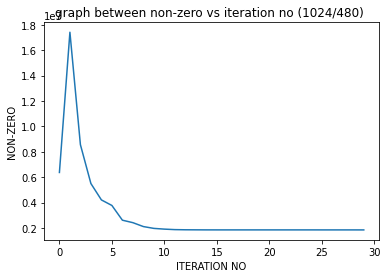

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

# x axis values
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
# corresponding y axis values
y = [  6374505,
   17406000 ,
   8562176 ,
   5503360 ,
   4215712 ,
   3779040 ,
   2620832 ,
   2425696 ,
  2118688 ,
   1975232 ,
   1917600 ,
   1879072 ,
  1866112 ,
   1862048 ,
   1858560 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
   1857536 ,
  1857536 ,
   1856512 ,
   1856512 ,
   1856512 ,
   1856512 ,
  1855488 ]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('ITERATION NO')
# naming the y axis
plt.ylabel('NON-ZERO')

# giving a title to my graph
plt.title('graph between non-zero vs iteration no (1024/480) ')

# function to show the plot
plt.show()


1024/1920

In [ ]:
%%cu
#include <fstream>
#include <iostream>
#include <string>
#include <vector>
#include <boost/algorithm/string.hpp>
#include <stdio.h>
#include <string.h>
#define row 60000
#define col 1024
#include <sys/time.h>
using namespace std;
using namespace boost::algorithm;
using std::cout; using std::cerr;
using std::endl; using std::string;
using std::ifstream; using std::vector;


__global__ void passed_failed(int* cat_120, int* cat_calculated)
{
    int index=blockIdx.x*blockDim.x+threadIdx.x;
    if(index<1812)

    {
        if(cat_120[index]!=cat_calculated[index])
       {
         printf("Test Failed \n");
           return;
        }
        printf("index %d ,v1 %d = v2 %d \n " ,index,cat_120[index],cat_calculated[index]);
    }

     __syncthreads();
    printf("Test Passed \n");
}

__global__ void count(float* M,int *count,int*Tcd)
{
    int index=blockIdx.x*blockDim.x+threadIdx.x;

   // int index_cnt=0;
    if(index<60000   )
    {
        for(int i=0;i<1024;i++)
        {
          if(M[index*1024+i]!=0)
          {
              //printf("Active %d ",index);

              //Tcd[index_cnt]=index;
              //index_cnt =index_cnt+1;

              atomicAdd(count,1);
              break;
          }
        }
          __syncthreads();
    }
     __syncthreads();

}

__global__ void Kernel(float * M,float* N,float * P)
{

    int Row=blockIdx.y*blockDim.y+threadIdx.y;
    int Col=blockIdx.x*blockDim.x+threadIdx.x;

    if(Row<60000 && Col < 1024)
    {
        float product=0;
        for(int k=0;k<1024;k++)
            product+=M[Row*1024+k]*N[k*1024+Col];

    //    printf("Pro %f col > %d ",product , Col);

        product = product - 0.3;
        if((product)<0)
        {
            product = 0;
        }
        if((product) >32)
        {
            product = 32;
        }
        P[Row*1024+Col]=product;
    }
    __syncthreads();
}
int main(int argc, char** argv) {

    ifstream fin("drive/MyDrive/sparse-images-1024.tsv");
    string line;
    float *y_o;
    int N=60000*1024*sizeof(float);
    y_o=(float*)malloc(N);
    for(int i=0; i<row*col; i++){
        y_o[i]=0;
    }

    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);

        y_o[(r-1)*1024+(c-1)]=1;
    }
    fin.close();





/////////////////////////////////////////////////////////////////////////////////////////////////////////

float inference_time = 0;

for(int i=1; i<=500; i++){

    string  fname="n1024-l";
    string add=to_string(i);
    fname="drive/MyDrive/neuron1024/"+fname+add+".tsv";
   // cout<<fname<<endl;
    ifstream fin(fname);
    string line;
    float *wt;
    int N=1024*1024*sizeof(float);
    wt=(float*)malloc(N);
   for(int i=0; i<1024*1024; i++){
        wt[i]=0;
    }


    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);
        wt[(r-1)*1024+(c-1)]=0.0625;
        //cout <<" elements: " << parts[0]<<"," << parts[1]<<", " <<parts[2]<<endl;
    }

    fin.close();

// Allocating device memory for Y
    float *D_Y;
    cudaMalloc(&D_Y,60000*1024*sizeof(float));

//Allocating device memory for weight matrix

    float *D_W;
    cudaMalloc(&D_W,1024*1024*sizeof(float));

//Allocating device memory for product matrix

    float* D_P;
    cudaMalloc(&D_P,60000*1024*sizeof(float));




// Copying Hy to DY

    // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);
    cudaMemcpy(D_Y,y_o,60000*1024*sizeof(float),cudaMemcpyHostToDevice);



// Copying HW TO DW
    cudaMemcpy(D_W,wt,1024*1024*sizeof(float),cudaMemcpyHostToDevice);


// Kernel call
    dim3 dimGrid(32, 1875);
    dim3 dimBlock(32, 32);






    Kernel<<<dimGrid, dimBlock>>>(D_Y, D_W, D_P);
    cudaDeviceSynchronize();




      cudaMemcpy(y_o,D_P,60000*1024*sizeof(float),cudaMemcpyDeviceToHost);
    // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    //printf("Time measured: %.6f seconds.\n", elapsed);

    inference_time = inference_time + elapsed;

    free(wt);
    cudaFree(D_Y);
    cudaFree(D_W);
    cudaFree(D_P);

}


string filename("drive/MyDrive/neuron1024-l1920-categories.tsv");
vector<string> lines;
string linev;
int *Tch;
Tch=(int*)malloc(2000*sizeof(int));
int* cat_120;

cat_120=(int*) malloc(2000*sizeof(int));

for(int i=0;i<2000;i++)
{
    cat_120[i]=0;
     Tch[i]=0;
}

    ifstream input_file(filename);
    if (!input_file.is_open()) {
        cerr << "Could not open the file - '"
             << filename << "'" << endl;
        return EXIT_FAILURE;
    }
int h=0;
    while (getline(input_file, linev)){
        int cat_val = stoi(linev);
        //printf("Value_of cat %d ",cat_val);
        cat_120[h]=cat_val;
        h++;

    }
printf("\n");


int *  activimg;
activimg = (int*) malloc(sizeof(int));
int * activimgd;
cudaMalloc(&activimgd,sizeof(int));
*activimg=0;
printf("Actidakdja %d ",*activimg);

cudaMemcpy(activimgd,activimg,sizeof(int),cudaMemcpyHostToDevice);
float* final_feature_device;

cudaMalloc(&final_feature_device,60000*1024*sizeof(float));

cudaMemcpy(final_feature_device,y_o,60000*1024*sizeof(float),cudaMemcpyHostToDevice);

int * Tcd;
cudaMalloc(&Tcd,2000*sizeof(int));

cudaMemcpy(Tcd,Tch,2000*sizeof(int),cudaMemcpyHostToDevice);

count<<<60,1024>>>(final_feature_device,activimgd,Tcd);

cudaDeviceSynchronize();

cudaMemcpy(activimg,activimgd,sizeof(int),cudaMemcpyDeviceToHost);
cudaMemcpy(Tch,Tcd,1812*sizeof(int),cudaMemcpyDeviceToHost);

int * compare;
compare = (int*) malloc (1812*sizeof(int));
for(int i=0;i<1812;i++)
{
    compare[i]=0;
}



int cindex=0;


  for(int i=0;i<60000;i++)
  {
      for(int j=0;j<1024;j++)
      {
          if(y_o[i*1024+j]!=0)
          {
            printf("Image %d Active ",i+1);
            compare[cindex]=i+1;
            cindex++;

            break;
          }
      }
  }


  int * compare_device;
  cudaMalloc(&compare_device,1812*sizeof(int));

  cudaMemcpy(compare_device,compare,1812*sizeof(int),cudaMemcpyHostToDevice);

  int * given_compare_device;
    cudaMalloc(&given_compare_device,1812*sizeof(int));

    cudaMemcpy(given_compare_device,cat_120,1812*sizeof(int),cudaMemcpyHostToDevice);

    //verification

        // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);




    passed_failed<<<2,1024>>>(given_compare_device,compare_device);

    cudaDeviceSynchronize();


        // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double Verify = seconds + microseconds*1e-6;

    printf("Verified in: %.6f seconds.\n", Verify);









  printf("\n");
/*
  for(int i=0;i<1812;i++)
  {
      if(cat_120[i]!=compare[i])
      {
          printf("%d %d \n",cat_120[i],compare[i]);
          printf("Test Failed \n");
      }
  }
*/
  //  printf("Test Passed \n");

    printf("Total Active images %d \n",*activimg);

    printf("Inference Time %f " , inference_time);

    return 0;
}

UsageError: Cell magic `%%cu` not found.


4096/120

In [ ]:
%%cu
#include <fstream>
#include <iostream>
#include <string>
#include <vector>
#include <boost/algorithm/string.hpp>
#include <stdio.h>
#include <string.h>
#define row 60000
#define col 4096
#include <sys/time.h>
using namespace std;
using namespace boost::algorithm;
using std::cout; using std::cerr;
using std::endl; using std::string;
using std::ifstream; using std::vector;


__global__ void passed_failed(int* cat_120, int* cat_calculated)
{
    int index=blockIdx.x*blockDim.x+threadIdx.x;
    if(index<1812)

    {
        if(cat_120[index]!=cat_calculated[index])
       {
         printf("Test Failed \n");
           return;
        }
        printf("index %d ,v1 %d = v2 %d \n " ,index,cat_120[index],cat_calculated[index]);
    }

     __syncthreads();
    printf("Test Passed \n");
}

__global__ void count(float* M,int *count,int*Tcd)
{
    int index=blockIdx.x*blockDim.x+threadIdx.x;

   // int index_cnt=0;
    if(index<60000   )
    {
        for(int i=0;i<4096;i++)
        {
          if(M[index*4096+i]!=0)
          {
              //printf("Active %d ",index);

              //Tcd[index_cnt]=index;
              //index_cnt =index_cnt+1;

              atomicAdd(count,1);
              break;
          }
        }
          __syncthreads();
    }
     __syncthreads();

}

__global__ void Kernel(float * M,float* N,float * P)
{

    int Row=blockIdx.y*blockDim.y+threadIdx.y;
    int Col=blockIdx.x*blockDim.x+threadIdx.x;

    if(Row<60000 && Col < 4096)
    {
        float product=0;
        for(int k=0;k<4096;k++)
            product+=M[Row*4096+k]*N[k*4096+Col];

    //    printf("Pro %f col > %d ",product , Col);

        product = product - 0.3;
        if((product)<0)
        {
            product = 0;
        }
        if((product) >32)
        {
            product = 32;
        }
        P[Row*4096+Col]=product;
    }
    __syncthreads();
}
int main(int argc, char** argv) {

    ifstream fin("drive/MyDrive/sparse-images-4096.tsv");
    string line;
    float *y_o;
    int N=60000*4096*sizeof(float);
    y_o=(float*)malloc(N);
    for(int i=0; i<row*col; i++){
        y_o[i]=0;
    }

    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);

        y_o[(r-1)*4096+(c-1)]=1;
    }
    fin.close();





/////////////////////////////////////////////////////////////////////////////////////////////////////////

float inference_time = 0;

for(int i=1; i<=1; i++){

    string  fname="4096-l";
    string add=to_string(i);
    fname="drive/MyDrive/neuron4096/"+fname+add+".tsv";
   // cout<<fname<<endl;
    ifstream fin(fname);
    string line;
    float *wt;
    int N=4096*4096*sizeof(float);
    wt=(float*)malloc(N);
   for(int i=0; i<4096*4096; i++){
        wt[i]=0;
    }


    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);
        wt[(r-1)*4096+(c-1)]=0.0625;
        //cout <<" elements: " << parts[0]<<"," << parts[1]<<", " <<parts[2]<<endl;
    }

    fin.close();

// Allocating device memory for Y
    float *D_Y;
    cudaMalloc(&D_Y,60000*4096*sizeof(float));

//Allocating device memory for weight matrix

    float *D_W;
    cudaMalloc(&D_W,4096*4096*sizeof(float));

//Allocating device memory for product matrix

    float* D_P;
    cudaMalloc(&D_P,60000*4096*sizeof(float));




// Copying Hy to DY

    // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);
    cudaMemcpy(D_Y,y_o,60000*4096*sizeof(float),cudaMemcpyHostToDevice);



// Copying HW TO DW
    cudaMemcpy(D_W,wt,4096*4096*sizeof(float),cudaMemcpyHostToDevice);


// Kernel call
    dim3 dimGrid(128, 1875);
    dim3 dimBlock(32, 32);






    Kernel<<<dimGrid, dimBlock>>>(D_Y, D_W, D_P);
    cudaDeviceSynchronize();




      cudaMemcpy(y_o,D_P,60000*4096*sizeof(float),cudaMemcpyDeviceToHost);
    // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    //printf("Time measured: %.6f seconds.\n", elapsed);

    inference_time = inference_time + elapsed;

    free(wt);
    cudaFree(D_Y);
    cudaFree(D_W);
    cudaFree(D_P);

}


string filename("drive/MyDrive/neuron4096-l120-categories.tsv");
vector<string> lines;
string linev;
int *Tch;
Tch=(int*)malloc(2000*sizeof(int));
int* cat_120;

cat_120=(int*) malloc(2000*sizeof(int));

for(int i=0;i<2000;i++)
{
    cat_120[i]=0;
     Tch[i]=0;
}

    ifstream input_file(filename);
    if (!input_file.is_open()) {
        cerr << "Could not open the file - '"
             << filename << "'" << endl;
        return EXIT_FAILURE;
    }
int h=0;
    while (getline(input_file, linev)){
        int cat_val = stoi(linev);
        printf("Value_of cat %d ",cat_val);
        cat_120[h]=cat_val;
        h++;

    }
printf("\n");


int *  activimg;
activimg = (int*) malloc(sizeof(int));
int * activimgd;
cudaMalloc(&activimgd,sizeof(int));
*activimg=0;
printf("Actidakdja %d ",*activimg);

cudaMemcpy(activimgd,activimg,sizeof(int),cudaMemcpyHostToDevice);
float* final_feature_device;

cudaMalloc(&final_feature_device,60000*4096*sizeof(float));

cudaMemcpy(final_feature_device,y_o,60000*4096*sizeof(float),cudaMemcpyHostToDevice);

int * Tcd;
cudaMalloc(&Tcd,2000*sizeof(int));

cudaMemcpy(Tcd,Tch,2000*sizeof(int),cudaMemcpyHostToDevice);

count<<<60,1024>>>(final_feature_device,activimgd,Tcd);

cudaDeviceSynchronize();

cudaMemcpy(activimg,activimgd,sizeof(int),cudaMemcpyDeviceToHost);
cudaMemcpy(Tch,Tcd,1812*sizeof(int),cudaMemcpyDeviceToHost);

int * compare;
compare = (int*) malloc (1812*sizeof(int));
for(int i=0;i<1812;i++)
{
    compare[i]=0;
}



int cindex=0;


  for(int i=0;i<60000;i++)
  {
      for(int j=0;j<4096;j++)
      {
          if(y_o[i*4096+j]!=0)
          {
            printf("Image %d Active ",i+1);
            compare[cindex]=i+1;
            cindex++;

            break;
          }
      }
  }


  int * compare_device;
  cudaMalloc(&compare_device,1812*sizeof(int));

  cudaMemcpy(compare_device,compare,1812*sizeof(int),cudaMemcpyHostToDevice);

  int * given_compare_device;
    cudaMalloc(&given_compare_device,1812*sizeof(int));

    cudaMemcpy(given_compare_device,cat_120,1812*sizeof(int),cudaMemcpyHostToDevice);

    //verification

        // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);




    //passed_failed<<<2,1024>>>(given_compare_device,compare_device);

    cudaDeviceSynchronize();


        // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double Verify = seconds + microseconds*1e-6;

    printf("Verified in: %.6f seconds.\n", Verify);









  printf("\n");
/*
  for(int i=0;i<1812;i++)
  {
      if(cat_120[i]!=compare[i])
      {
          printf("%d %d \n",cat_120[i],compare[i]);
          printf("Test Failed \n");
      }
  }
*/
  //  printf("Test Passed \n");

    printf("Total Active images %d \n",*activimg);

    printf("Inference Time %f " , inference_time);

    return 0;
}

Value_of cat 29 Value_of cat 188 Value_of cat 287 Value_of cat 295 Value_of cat 386 Value_of cat 427 Value_of cat 571 Value_of cat 757 Value_of cat 815 Value_of cat 943 Value_of cat 945 Value_of cat 991 Value_of cat 1011 Value_of cat 1031 Value_of cat 1097 Value_of cat 1098 Value_of cat 1177 Value_of cat 1184 Value_of cat 1200 Value_of cat 1208 Value_of cat 1210 Value_of cat 1214 Value_of cat 1216 Value_of cat 1220 Value_of cat 1246 Value_of cat 1250 Value_of cat 1254 Value_of cat 1256 Value_of cat 1262 Value_of cat 1263 Value_of cat 1268 Value_of cat 1270 Value_of cat 1272 Value_of cat 1274 Value_of cat 1298 Value_of cat 1300 Value_of cat 1302 Value_of cat 1304 Value_of cat 1310 Value_of cat 1328 Value_of cat 1346 Value_of cat 1364 Value_of cat 1368 Value_of cat 1372 Value_of cat 1394 Value_of cat 1396 Value_of cat 1398 Value_of cat 1449 Value_of cat 1467 Value_of cat 1490 Value_of cat 1496 Value_of cat 1551 Value_of cat 1619 Value_of cat 1703 Value_of cat 1725 Value_of cat 1827 Value

In [ ]:
%%cu
#include <sys/time.h>
#include <fstream>
#include <iostream>
#include <string>
#include <vector>
#include <boost/algorithm/string.hpp>
#include <stdio.h>
#include <string.h>
#define row 60000
#define col 1024
using namespace std;
using namespace boost::algorithm;

__global__ void Kernel(float * IMG,int* Rptr,int* Cptr,float * value,float* D_P){
      int id=threadIdx.x;
      int ind=blockIdx.x;
        float prdt=0;
        for(int i=Rptr[id]; i<Rptr[id+1]; i++){
            prdt+=IMG[ind*1024+Cptr[i]]*value[i];
        }
        prdt-=0.3;
        if(prdt<0)prdt=0;
        if(prdt>32)prdt=32;
        D_P[ind*1024+id]=prdt;
        __syncthreads();

}

int main(int argc, char** argv) {
    ifstream fin("drive/MyDrive/sparse-images-1024.tsv");
    string line;
    float *y_o;
    int N=60000*1024*sizeof(float);
    y_o=(float*)malloc(N);
    for(int i=0; i<row*col; i++){
        y_o[i]=0;
    }
//Taking image input from file
    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);
        y_o[(r-1)*1024+(c-1)]=1;
    }
    fin.close();

///////////////////////////////// for 600000 image //////////////////////////


      float *image1;
      image1 = (float* ) malloc(60000*1024*sizeof(float));

      int cnt=0;
      for(int i=0; i<60000*1024; i++ ){
          if(y_o[i]!=0)cnt++;
          image1[i]=y_o[i];
      }
      // printf("non zero in first image before multiplication %d ",cnt);
  for(int i=1; i<120; i++){

      string  fname="n1024-l";
      string add=to_string(i);
      fname="drive/MyDrive/neuron1024/"+fname+add+".tsv";
      //cout<<"file name: "<<fname<<endl;
      ifstream fin(fname);
      string line;
      float *wt;
      wt=(float*)malloc(1024*1024*sizeof(float));
      for(int i=0; i<1024*1024; i++){
          wt[i]=0;
      }
      int nzr=0;
      while (getline(fin, line)) {
          vector<string> parts;
          split(parts, line, boost::is_any_of("\t"));
          string st1 = parts[0];
          int r = stoi(st1);
          string st2 = parts[1];
          int c = stoi(st2);
          wt[(c-1)*1024+(r-1)]=0.0625;
          nzr++;
          //cout <<" elements: " << parts[0]<<"," << parts[1]<<", " <<parts[2]<<endl;
      }
      fin.close();
     // printf("nzr in wt%d= %d\n",i,nzr);
      int* row_ptr,*col_ptr;
      float* value;
      row_ptr=(int*)malloc(1025*sizeof(int));
      col_ptr=(int*)malloc(nzr*sizeof(int));
      value=(float*)malloc(nzr*sizeof(float));
      for(int i=0; i<1025; i++){
          row_ptr[i]=0;
      }
      for(int i=0; i<nzr; i++){
          col_ptr[i]=0; value[i]=0;
      }
      int k=0,l=0,nz=0;
      for(int x=0; x<1024; x++){
          for(int j=0; j<1024; j++){
              if(wt[x*1024+j]!=0){
                  col_ptr[k++]=j;
                  value[l++]=wt[x*1024+j];
                  nz++;
              }
          }
          row_ptr[x+1]=nz;
      }
/*
    for(int i=0; i<1024; i++){
        printf("%d->",row_ptr[i]);
        for(int j=row_ptr[i]; j<row_ptr[i+1]; j++){
            printf("%f,",value[j]);
        }
        printf("\n");
    }
    */

  //////////////////// Taking only one image /////////////////////

      float *dimg1;
          // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);

      cudaMalloc(&dimg1,60000*1024*sizeof(float));
      cudaMemcpy(dimg1,image1,60000*1024*sizeof(float),cudaMemcpyHostToDevice);
  //Allocating device memory for weight matrix

      int *D_rptr;
      cudaMalloc(&D_rptr,1025*sizeof(int));
      cudaMemcpy(D_rptr,row_ptr,1025*sizeof(int),cudaMemcpyHostToDevice);
    //////////
    int *D_cptr;
      cudaMalloc(&D_cptr,nzr*sizeof(int));
      cudaMemcpy(D_cptr,col_ptr,nzr*sizeof(int),cudaMemcpyHostToDevice);
  //Allocating device memory for product matrix

      float* D_value;
      cudaMalloc(&D_value,nzr*sizeof(float));
      cudaMemcpy(D_value,value,nzr*sizeof(float),cudaMemcpyHostToDevice);
 // TO store pruduct///
      float* D_P;
      cudaMalloc(&D_P,60000*1024*sizeof(float));
/////////// kernal call //////////

      Kernel<<<60000,1024>>>(dimg1,D_rptr,D_cptr,D_value, D_P);
      cudaDeviceSynchronize();
      cudaMemcpy(image1,D_P,60000*1024*sizeof(float),cudaMemcpyDeviceToHost);

          // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    printf("Time measured: %.6f seconds.\n", elapsed);

      free(wt);
      cudaFree(dimg1);
      cudaFree(D_rptr);
      cudaFree(D_P);
}
      int cnt2=0;
      for(int i=0; i<60000; i++){
          for(int j=0; j<1024; j++){
            if(image1[i*1024+j]!=0){
                printf("%d \n",i+1);
                cnt2++;
                 break;
            }
         }
      }
     printf("\n nonzero in image=%d \n",cnt2);
  return 0;
}


Time measured: 0.648093 seconds.
Time measured: 0.234582 seconds.
Time measured: 0.232309 seconds.
Time measured: 0.232180 seconds.
Time measured: 0.234017 seconds.
Time measured: 0.232422 seconds.
Time measured: 0.240127 seconds.
Time measured: 0.239705 seconds.
Time measured: 0.239951 seconds.
Time measured: 0.239621 seconds.
Time measured: 0.240186 seconds.
Time measured: 0.240017 seconds.
Time measured: 0.239136 seconds.
Time measured: 0.239456 seconds.
Time measured: 0.239670 seconds.
Time measured: 0.241231 seconds.
Time measured: 0.239857 seconds.
Time measured: 0.239715 seconds.
Time measured: 0.239106 seconds.
Time measured: 0.237427 seconds.
Time measured: 0.239431 seconds.
Time measured: 0.240960 seconds.
Time measured: 0.239666 seconds.
Time measured: 0.242069 seconds.
Time measured: 0.239862 seconds.
Time measured: 0.239817 seconds.
Time measured: 0.240860 seconds.
Time measured: 0.240763 seconds.
Time measured: 0.242732 seconds.
Time measured: 0.240674 seconds.
Time measu

4096 image size

In [ ]:
%%cu
#include <sys/time.h>
#include <fstream>
#include <iostream>
#include <string>
#include <vector>
#include <boost/algorithm/string.hpp>
#include <stdio.h>
#include <string.h>
#define row 60000
#define col 1024
using namespace std;
using namespace boost::algorithm;

__global__ void Kernel(float * IMG,int* Rptr,int* Cptr,float * value,float* D_P){
      int id=threadIdx.x;
      int ind=blockIdx.x;
        float prdt=0;
        for(int i=Rptr[id]; i<Rptr[id+1]; i++){
            prdt+=IMG[ind*1024+Cptr[i]]*value[i];
        }
        prdt-=0.35;
        if(prdt<0)prdt=0;
        if(prdt>32)prdt=32;
        D_P[ind*1024+id]=prdt;
        __syncthreads();

}

int main(int argc, char** argv) {
    ifstream fin("drive/MyDrive/sparse-images-4096.tsv");
    string line;
    float *y_o;
    int N=60000*4096*sizeof(float);
    y_o=(float*)malloc(N);
    for(int i=0; i<row*col; i++){
        y_o[i]=0;
    }
//Taking image input from file
    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);
        y_o[(r-1)*4096+(c-1)]=1;
    }
    fin.close();

///////////////////////////////// for 600000 image //////////////////////////


      float *image1;
      image1 = (float* ) malloc(60000*4096*sizeof(float));

      int cnt=0;
      for(int i=0; i<60000*4096; i++ ){
          if(y_o[i]!=0)cnt++;
          image1[i]=y_o[i];
      }
      // printf("non zero in first image before multiplication %d ",cnt);
  for(int i=1; i<20; i++){

      string  fname="n1024-l";
      string add=to_string(i);
      fname="drive/MyDrive/neuron4096/"+fname+add+".tsv";
      //cout<<"file name: "<<fname<<endl;
      ifstream fin(fname);
      string line;
      float *wt;
      wt=(float*)malloc(4096*4096*sizeof(float));
      for(int i=0; i<4096*4096; i++){
          wt[i]=0;
      }
      int nzr=0;
      while (getline(fin, line)) {
          vector<string> parts;
          split(parts, line, boost::is_any_of("\t"));
          string st1 = parts[0];
          int r = stoi(st1);
          string st2 = parts[1];
          int c = stoi(st2);
          wt[(c-1)*4096+(r-1)]=0.0625;
          nzr++;
          //cout <<" elements: " << parts[0]<<"," << parts[1]<<", " <<parts[2]<<endl;
      }
      fin.close();
     // printf("nzr in wt%d= %d\n",i,nzr);
      int* row_ptr,*col_ptr;
      float* value;
      row_ptr=(int*)malloc(4097*sizeof(int));
      col_ptr=(int*)malloc(nzr*sizeof(int));
      value=(float*)malloc(nzr*sizeof(float));
      for(int i=0; i<4097; i++){
          row_ptr[i]=0;
      }
      for(int i=0; i<nzr; i++){
          col_ptr[i]=0; value[i]=0;
      }
      int k=0,l=0,nz=0;
      for(int x=0; x<4096; x++){
          for(int j=0; j<4096; j++){
              if(wt[x*4096+j]!=0){
                  col_ptr[k++]=j;
                  value[l++]=wt[x*4096+j];
                  nz++;
              }
          }
          row_ptr[x+1]=nz;
      }
/*
    for(int i=0; i<1024; i++){
        printf("%d->",row_ptr[i]);
        for(int j=row_ptr[i]; j<row_ptr[i+1]; j++){
            printf("%f,",value[j]);
        }
        printf("\n");
    }
    */

  //////////////////// Taking only one image /////////////////////

      float *dimg1;
          // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);

      cudaMalloc(&dimg1,60000*4096*sizeof(float));
      cudaMemcpy(dimg1,image1,60000*4096*sizeof(float),cudaMemcpyHostToDevice);
  //Allocating device memory for weight matrix

      int *D_rptr;
      cudaMalloc(&D_rptr,4097*sizeof(int));
      cudaMemcpy(D_rptr,row_ptr,4097*sizeof(int),cudaMemcpyHostToDevice);
    //////////
    int *D_cptr;
      cudaMalloc(&D_cptr,nzr*sizeof(int));
      cudaMemcpy(D_cptr,col_ptr,nzr*sizeof(int),cudaMemcpyHostToDevice);
  //Allocating device memory for product matrix

      float* D_value;
      cudaMalloc(&D_value,nzr*sizeof(float));
      cudaMemcpy(D_value,value,nzr*sizeof(float),cudaMemcpyHostToDevice);
 // TO store pruduct///
      float* D_P;
      cudaMalloc(&D_P,60000*4096*sizeof(float));
/////////// kernal call //////////

      Kernel<<<60000,1024>>>(dimg1,D_rptr,D_cptr,D_value, D_P);
      cudaDeviceSynchronize();
      cudaMemcpy(image1,D_P,60000*4096*sizeof(float),cudaMemcpyDeviceToHost);

          // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    printf("Time measured: %.6f seconds.\n", elapsed);

      free(wt);
      cudaFree(dimg1);
      cudaFree(D_rptr);
      cudaFree(D_P);
}
      int cnt2=0;
      for(int i=0; i<60000; i++){
          for(int j=0; j<4096; j++){
            if(image1[i*4096+j]!=0){
                printf("%d \n",i+1);
                cnt2++;
                 break;
            }
         }
      }
     printf("\n nonzero in image=%d \n",cnt2);
  return 0;
}


UsageError: Cell magic `%%cu` not found.


4096 120

In [ ]:
%%cu
#include <fstream>
#include <iostream>
#include <string>
#include <vector>
#include <boost/algorithm/string.hpp>
#include <stdio.h>
#include <string.h>
#define row 60000
#define col 4096
#include <sys/time.h>
using namespace std;
using namespace boost::algorithm;

__global__ void Kernel(float * M,float* N,float * P)
{

    int Row=blockIdx.y*blockDim.y+threadIdx.y;
    int Col=blockIdx.x*blockDim.x+threadIdx.x;

    if(Row<60000 && Col < 4096)
    {
        float product=0;
        for(int k=0;k<4096;k++)
            product+=M[Row*4096+k]*N[k*4096+Col];

    //    printf("Pro %f col > %d ",product , Col);

        product = product - 0.35;
        if((product)<0)
        {
            product = 0;
        }
        if((product) >32)
        {
            product = 32;
        }
        P[Row*4096+Col]=product;
    }
    __syncthreads();
}
int main(int argc, char** argv) {

    ifstream fin("drive/MyDrive/sparse-images-4096.tsv");
    string line;
    float *y_o;
    int N=60000*4096*sizeof(float);
    y_o=(float*)malloc(N);
    for(int i=0; i<row*col; i++){
        y_o[i]=0;
    }

    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);

        y_o[(r-1)*4096+(c-1)]=1;
    }
    fin.close();



    int cnt=0;


    for(int i=0;i<60000*4096;i++)
    {
        if(y_o[i]==1)
        {
            cnt++;
        }
    }
    printf("Before Multiplication %d \n ", cnt);

/////////////////////////////////////////////////////////////////////////////////////////////////////////



for(int i=1; i<=30; i++){

    string  fname="n4096-l";
    string add=to_string(i);
    fname="drive/MyDrive/neuron4096/"+fname+add+".tsv";
   // cout<<fname<<endl;
    ifstream fin(fname);
    string line;
    float *wt;
    int N=4096*4096*sizeof(float);
    wt=(float*)malloc(N);
   for(int i=0; i<4096*4096; i++){
        wt[i]=0;
    }


    while (getline(fin, line)) {
        // Split line into tab-separated parts
        vector<string> parts;
        split(parts, line, boost::is_any_of("\t"));
        // TODO Your code goes here!
        string st1 = parts[0];
        int r = stoi(st1);
        string st2 = parts[1];
         int c = stoi(st2);
        wt[(r-1)*4096+(c-1)]=0.0625;
        //cout <<" elements: " << parts[0]<<"," << parts[1]<<", " <<parts[2]<<endl;
    }

    fin.close();

// Allocating device memory for Y
    float *D_Y;
    cudaMalloc(&D_Y,60000*4096*sizeof(float));

//Allocating device memory for weight matrix

    float *D_W;
    cudaMalloc(&D_W,4096*4096*sizeof(float));

//Allocating device memory for product matrix

    float* D_P;
    cudaMalloc(&D_P,60000*4096*sizeof(float));

              // Start measuring time
    struct timeval begin, end;
    gettimeofday(&begin, 0);


// Copying Hy to DY
    cudaMemcpy(D_Y,y_o,60000*4096*sizeof(float),cudaMemcpyHostToDevice);



// Copying HW TO DW
    cudaMemcpy(D_W,wt,4096*4096*sizeof(float),cudaMemcpyHostToDevice);


// Kernel call
    dim3 dimGrid(130, 1875);
    dim3 dimBlock(32, 32);
    Kernel<<<dimGrid, dimBlock>>>(D_Y, D_W, D_P);
    cudaDeviceSynchronize();
      cudaMemcpy(y_o,D_P,60000*4096*sizeof(float),cudaMemcpyDeviceToHost);

                // Stop measuring time and calculate the elapsed time
    gettimeofday(&end, 0);
    long seconds = end.tv_sec - begin.tv_sec;
    long microseconds = end.tv_usec - begin.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    printf("Time measured: %.6f seconds.\n", elapsed);

      int cnt2=0;
      for(int i=0;i<60000* 4096;i++)
      {
          if(y_o[i] !=0)
          {

              cnt2++;
          }
      }
    printf(" After iteration %d nnz -> %d \n ", i, cnt2);

    free(wt);
    cudaFree(D_Y);
    cudaFree(D_W);
    cudaFree(D_P);

}




int activimg=0;
  for(int i=0;i<100;i++)
  {
      for(int j=0;j<4096;j++)
      {
          if(y_o[i*4096+j]!=0)
          {
            printf("Image %d Active ",i+1);
           activimg++;
            break;
          }
      }
  }
    printf("Total Active images %d",activimg);
    return 0;
}

Before Multiplication 25019051 
 Time measured: 3.260490 seconds.
 After iteration 1 nnz -> 53711648 
 Time measured: 3.190494 seconds.
 After iteration 2 nnz -> 23086416 
 Time measured: 3.174488 seconds.
 After iteration 3 nnz -> 14676640 
 Time measured: 3.176658 seconds.
 After iteration 4 nnz -> 11964656 
 Time measured: 3.186787 seconds.
 After iteration 5 nnz -> 11467456 
 Time measured: 3.187695 seconds.
 After iteration 6 nnz -> 11247952 
 Time measured: 3.194738 seconds.
 After iteration 7 nnz -> 8702368 
 Time measured: 3.204308 seconds.
 After iteration 8 nnz -> 7650368 
 Time measured: 3.203770 seconds.
 After iteration 9 nnz -> 8747808 
 Time measured: 3.208927 seconds.
 After iteration 10 nnz -> 8024288 
 Time measured: 3.215293 seconds.
 After iteration 11 nnz -> 7648416 
 Time measured: 3.220652 seconds.
 After iteration 12 nnz -> 7520656 
 Time measured: 3.232878 seconds.
 After iteration 13 nnz -> 7471104 
 Time measured: 3.228125 seconds.
 After iteration 14 nnz -> 